# 1-D Heat Flow

This notebook provide a demo case on the application of the heat conduction solver.
The numerical solver is discretised in time and space.  The solver uses backward Euler centered differencing with Newton iteration.

The heatConduction package contains necessary components to solve the PDEs. To just use it as a solver, simply passing the generated parameters to the solve function and execute. <br>
The solution process will be displayed as, time step, physical time, number of Newton's iteration and residual.

The `preprocess()` function transform the results  numpy array into a Pandas DataFrame, with index as grid locations and columns as timings.

In [1]:
# try:
#     import cupy as np                    
# except ImportError:
import numpy as np

import pandas as pd

import heatConduction as hc
import postprocessing as pp

## Steel

### Stationary boundary condition

This is the reference calculation, to be the same as the original case.

Set up the parameters into a pandas series

A single  emissivity value serves for both radiative loss and solar irradiance.

The atmospheric transmittance accounts for the mean atmospheric transmittance for a slant path to space.

The solar constant is the flux density at the top of the atmosphere.

In [2]:
column = 'values'
paras = pd.Series(name = column,dtype='object')
# paras = paras.astype('object')

# Grid
paras['length'] = 0.05
paras['numberOfNode'] = 501

# Solution
paras['numberOfTimeStep'] = 50 
paras['deltaTime'] = 0.2
paras['maxIteration'] = 20
paras['convergence'] = 1E-10
paras['relaxation'] = 1 # value in [0-1] Very sensitive!!!
paras['showProg'] = False # print every time step

# Material
paras['material'] = 'steel'
paras['material function'] = 'constant'
paras['density'] = 7850        #  kg/m3
paras['conductivity'] = 60.5   #  W/(m.K)
paras['heatCapacity'] = 434    #  J/(m.K)
paras['diffusivity'] = paras['conductivity'] / (paras['density'] * paras['heatCapacity']) # m2/s
paras['penDepth'] = np.sqrt(7.7 * paras['diffusivity'] * paras['deltaTime'] )

# Initial conditions
paras['Initial value'] = 298.  # K

# Radiometry
paras['Do radiative'] = False
paras['Emissivity'] = 0.8
paras['AtmoTau'] = 0.8
paras['Solar constant'] = 1500 # W/m2 top of atmo

# Boundary conditions
x0 = np.linspace(0,75000,int(paras['numberOfTimeStep']))
valueX0 = 750000 * np.ones(x0.shape)
valueXL = 0 * np.ones(x0.shape)
paras['x=0 type'] = 'heatFlux'#'heatFlux' W/m2  or 'fixedTemperature' K
paras['x=0 value'] = valueX0 
paras['x=L type'] = 'heatFlux'#'heatFlux' W/m2  or 'fixedTemperature' K
paras['x=L value'] = valueXL

In [3]:
print(paras)

length                                                            0.05
numberOfNode                                                     501.0
numberOfTimeStep                                                  50.0
deltaTime                                                          0.2
maxIteration                                                      20.0
convergence                                                        0.0
relaxation                                                         1.0
showProg                                                           0.0
material                                                         steel
material function                                             constant
density                                                           7850
conductivity                                                      60.5
heatCapacity                                                       434
diffusivity                                                   0.000018
penDep

The `solve()` output the results and a cache. The results is a numpy array consisting of the evolution of each time step over the domain. The cache file is a Python dictionary consists of some variables used by debugging. 


In [4]:
results, cache = hc.solve(paras)

In [5]:
T = pp.preprocess(paras,results)

The first plot is the evolution field in both time and space. We can view the results in a 3D contour plot by just passing the processed T to the function evolutionField(). <br>
It can be seen that the temperature over the var is increasing as time elapses.

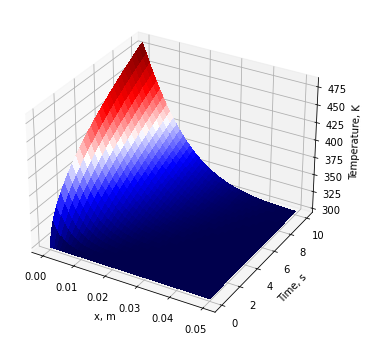

In [6]:
pp.evolutionField(T)

We can also check the temperature evolution for some specific locations, as there are thermal couples. <br>
Simply create a list of locations you want to check, and then pass the T and positions into the thermalCouplePlot() function.

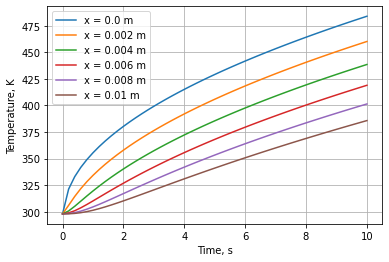

In [7]:
positions = [0, 0.002, 0.004, 0.006, 0.008, 0.01]
pp.thermalCouplePlot(T, positions)

We can futher check how the temperature is distributed over the domain at different times. Simply create a list of timings you want, and pass the T and times to the temperatureDistribution functions.

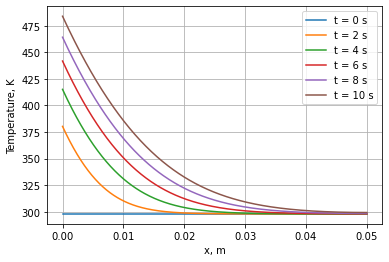

In [8]:
times = [0, 2, 4, 6, 8, 10]
pp.temperatureDistribution(T, times)

### Temporally variable boundary condition

First demo a linearly temporal-increasing input flux.



In [9]:
# Boundary conditions
x0 = np.linspace(0,paras['Solar constant'],int(paras['numberOfTimeStep']))
valueX0 = x0
valueXL = 0 * np.ones(x0.shape)
paras['x=0 type'] = 'heatFlux'#'heatFlux' W/m2  or 'fixedTemperature' K
paras['x=0 value'] = valueX0 
paras['x=L type'] = 'heatFlux'#'heatFlux' W/m2  or 'fixedTemperature' K
paras['x=L value'] = valueXL

print(paras)

length                                                            0.05
numberOfNode                                                     501.0
numberOfTimeStep                                                  50.0
deltaTime                                                          0.2
maxIteration                                                      20.0
convergence                                                        0.0
relaxation                                                         1.0
showProg                                                           0.0
material                                                         steel
material function                                             constant
density                                                           7850
conductivity                                                      60.5
heatCapacity                                                       434
diffusivity                                                   0.000018
penDep

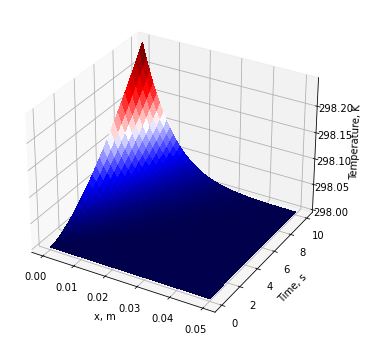

In [10]:
results, cache = hc.solve(paras)
T = pp.preprocess(paras, results)
pp.evolutionField(T)

Next use positive only sine curve of input heat flux.  Negative values set to zero.

No radiative heat loss.

In this case there is only positive heat flow into the sample, with no radiative heat loss.  The temperature rises.

In [11]:
# Boundary conditions

# Planck radiative heat loss
paras['Do radiative'] = False

paras['numberOfTimeStep'] = 1001
paras['deltaTime'] = 0.2
paras['penDepth'] = np.sqrt(7.7 * paras['diffusivity'] * paras['deltaTime'] )

# Grid
paras['length'] = 0.1
paras['numberOfNode'] = 501

totalTime = paras['numberOfTimeStep']  * paras['deltaTime'] 
t = np.linspace(0,totalTime,int(paras['numberOfTimeStep']))
freq = 0.025
valueX0 = paras['AtmoTau'] * paras['Emissivity'] * paras['Solar constant'] * np.sin(2*np.pi*t*freq)
valueX0 = np.where(valueX0>0,valueX0,0)
valueXL = 0 * np.ones(t.shape)
paras['x=0 type'] = 'heatFlux'#'heatFlux' W/m2  or 'fixedTemperature' K
paras['x=0 value'] = valueX0 
paras['x=L type'] = 'heatFlux'#'heatFlux' W/m2  or 'fixedTemperature' K
paras['x=L value'] = valueXL

print(paras)

length                                                             0.1
numberOfNode                                                       501
numberOfTimeStep                                                  1001
deltaTime                                                          0.2
maxIteration                                                      20.0
convergence                                                        0.0
relaxation                                                         1.0
showProg                                                           0.0
material                                                         steel
material function                                             constant
density                                                           7850
conductivity                                                      60.5
heatCapacity                                                       434
diffusivity                                                   0.000018
penDep

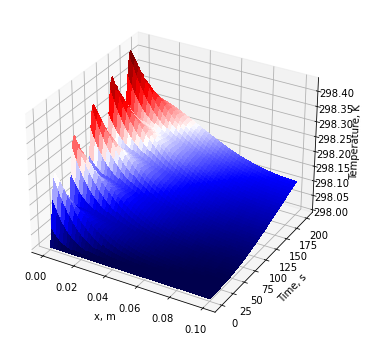

In [12]:
results, cache = hc.solve(paras)
T = pp.preprocess(paras, results)
pp.evolutionField(T)

Next use positive only sine curve of input heat flux.  Negative values set to zero.

The frequency is much higher than the earth's rotation.

The radiative heat loss significantly affects the surface temperature. Without radiative loss the temperature rises by 0.6 K and with radiative loss it only rises by 0.3 K.

In [13]:
# Boundary conditions

# Planck radiative heat loss
paras['Do radiative'] = True

print(paras)

length                                                             0.1
numberOfNode                                                       501
numberOfTimeStep                                                  1001
deltaTime                                                          0.2
maxIteration                                                      20.0
convergence                                                        0.0
relaxation                                                         1.0
showProg                                                           0.0
material                                                         steel
material function                                             constant
density                                                           7850
conductivity                                                      60.5
heatCapacity                                                       434
diffusivity                                                   0.000018
penDep

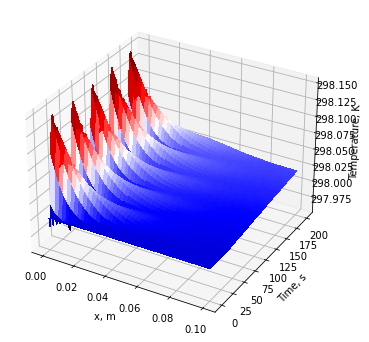

In [14]:
results, cache = hc.solve(paras)
T = pp.preprocess(paras, results)
pp.evolutionField(T)

## Real world conditions

Use one or more 24 hour days, with the frequency set to the earth's rotation.

Next use positive only sine curve of input heat flux.  Negative values set to zero.
The peak value of 1500 W/m2 corresponds roughly with the solar constant.

The radiative heat loss significantly affects the surface temperature. Without radiative loss the temperature rises by 0.6 K and with radiative loss it only rises by 0.3 K.

**The following cell takes a long time!**

In [15]:
# Boundary conditions

# Planck radiative heat loss
paras['Do radiative'] = True

numberDays = 100
freq =  1 / (60 * 60 * 24)

paras['numberOfTimeStep'] = numberDays * 144
paras['deltaTime'] = 600
paras['penDepth'] = np.sqrt(7.7 * paras['diffusivity'] * paras['deltaTime'] )

# Grid
paras['length'] = 2.
paras['numberOfNode'] = 201

totalTime = paras['numberOfTimeStep']  * paras['deltaTime'] 
t = np.linspace(0,totalTime,int(paras['numberOfTimeStep']))

valueX0 = paras['AtmoTau'] * paras['Emissivity'] * paras['Solar constant'] * np.sin(2*np.pi*t*freq)
valueX0 = np.where(valueX0>0,valueX0,0)
valueXL = 0 * np.ones(t.shape)
paras['x=0 type'] = 'heatFlux'#'heatFlux' W/m2  or 'fixedTemperature' K
paras['x=0 value'] = valueX0 
paras['x=L type'] = 'heatFlux'#'heatFlux' W/m2  or 'fixedTemperature' K
paras['x=L value'] = valueXL

print(paras)

length                                                             2.0
numberOfNode                                                       201
numberOfTimeStep                                                 14400
deltaTime                                                          600
maxIteration                                                      20.0
convergence                                                        0.0
relaxation                                                         1.0
showProg                                                           0.0
material                                                         steel
material function                                             constant
density                                                           7850
conductivity                                                      60.5
heatCapacity                                                       434
diffusivity                                                   0.000018
penDep

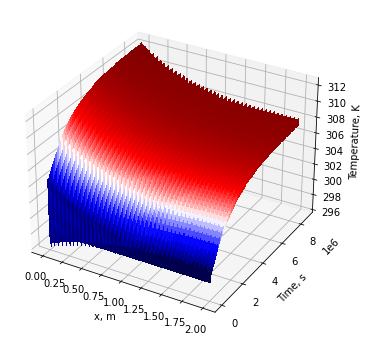

In [16]:
results, cache = hc.solve(paras)
T = pp.preprocess(paras, results)
pp.evolutionField(T)

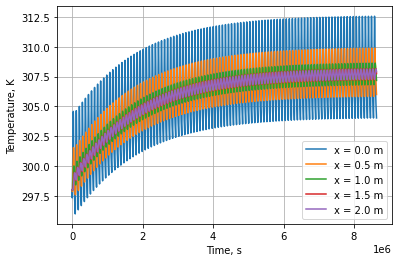

In [17]:
positions = [0,0.5,1.0,1.5,2]
pp.thermalCouplePlot(T, positions)